# Fine-tuning RoBERTa

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import psutil
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_scheduler

In [2]:
if torch.cuda.is_available(): device = torch.device("cuda")
elif torch.backends.mps.is_available(): device = torch.device("mps")
else: device = torch.device("cpu")

In [3]:
train = pd.read_csv("data/processed/train.csv")
test = pd.read_csv("data/processed/test.csv")

In [4]:
# Renaming id column as movie_id to avoid confusion
train = train.rename(columns={'id': 'movie_id'})
test = test.rename(columns={'id': 'movie_id'})

# Creating reviews id for matching with the original dataset
train['review_id'] = train.index + 1
test['review_id'] = test.index + 1

In [5]:
train = train.sample(frac=0.2, random_state=42).reset_index(drop=True)
test = test.sample(frac=0.2, random_state=42).reset_index(drop=True)

# 1. Build the model

First, we load the **base model** we intend to fine-tune along with the corresponding **tokenizer**.

RoBERTa is initialized with an untrained classifier head consisting of two dense (i.e., linear) layers:
- The first projects the output from the base model to a hidden space of the same dimensionality (1024 for RoBERTa-large).
- The second maps the hidden representation to the label space, reducing the dimensionality accordingly (to 2 for a binary classifier).

Since this classifier head is not pretrained, the warning below appears. It can either be fine-tuned directly or replaced with a custom classifier block.

The maximum input length of RoBERTa is 512 tokens. Sequences longer than this must be truncated before being passed to the model. Truncation parameters are set when loading the tokenizer. We opt for left-side truncation to preserve summaries that sometimes appear at the end of reviews. An alternative approach is to split long sequences into smaller chunks, process them sequentially, and average the results. However, this would be more complex to implement and may not yield reliable results.

In [6]:
# Load base model
model = AutoModelForSequenceClassification.from_pretrained('roberta-large')
tokenizer = AutoTokenizer.from_pretrained('roberta-large', truncation_side = 'left')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning is usually restricted to the final layers of the model responsible for the desired task. This approach speeds up training while preserving the knowledge acquired by the model during pretraining. Since we plan to implement a custom classifier block, we simply freeze all parameters of the base model (they are still trainable by default).

In [7]:
# Freeze pretrained layers 
print(f"Number of parameters in base RoBERTa: {sum(p.numel() for p in model.parameters())/1e6:.2f} M")

for param in model.parameters(): 
    param.requires_grad = False

print(f"Number of trainable parameters after freezing: {sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6:.2f}M")

Number of parameters in base RoBERTa: 355.36 M
Number of trainable parameters after freezing: 0.00M


There are two key decisions for the classifier head:
- Which layers to include
- Which input to use

Regarding the **layers**, a typical approach is to insert an activation layer and a dropout layer between the two projection layers of the initial classification head. The activation layer introduces non-linearity, while the dropout layer helps prevent overfitting. In our case, we expand the hidden space to 3072 to align with RoBERTa's intermediate size, chose a ReLU activation function, and set the dropout rate at 15 %.

Alternatively, as demonstrated [here](https://github.com/gnkhata1/Finetuning-BERT-on-Movie-Reviews-Sentiment-Analysis/blob/main/BERT%2BBiLSTM-SA.py), one can use an LSTM layer, a dropout, then a dense layer. This configuration is effective for capturing long-term dependencies across the sequences, but more computationaly expensive.

A final Softmax layer is necessary to obtain probabilities, and it is typically placed in the `predict` function (instead of `forward`) to simplify the computation of the loss.

Regarding the **input**:
- The simplest approach is to focus on the `[CLS]` token, which marks the beginning of the input sequence and serves as an embedding for its entirety: `x = outputs.last_hidden_state[:, 0, :]`
- Another approach is to pool all tokens from the input sequence, either by taking their mean or maximum: `x = torch.mean(outputs.last_hidden_state, dim=1)` or  `x = torch.max(outputs.last_hidden_state, dim=1).values()`
- The final option is to consider all tokens in the sequence, but this is only applicable when using an LSTM.

In [8]:
# Add layers for classification to finetune
class RoBERTa_architecture(nn.Module): 
    def __init__(self, roberta_model): 
        super(RoBERTa_architecture, self).__init__() 
        self.roberta = roberta_model
        # Dense layer 1
        self.fc1 = nn.Linear(1024, 3072)
        # Relu
        self.relu = nn.ReLU()
        # Dropout layer
        self.dropout = nn.Dropout(0.15)
        # Dense layer 2 (Output layer)
        self.fc2 = nn.Linear(3072, 2)
 
    def forward(self, sent_id, mask): 
        # Pass inputs to the base model
        outputs = self.roberta(sent_id, attention_mask=mask, return_dict=True)
        # Get CLS token representation
        x = outputs.last_hidden_state[:, 0, :]
        # Apply new layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

    def predict(self, sent_id, mask):
        self.eval()
        # Disable gradient calculation for inference
        with torch.no_grad():
            logits = self.forward(sent_id, mask)
        # Apply Softmax
        probs = F.softmax(logits, dim=1)
        # Retain highest probability
        preds = torch.argmax(x, dim=1)

        return preds

In [9]:
# Create the model
roberta_classifier = RoBERTa_architecture(model.roberta)
roberta_classifier = roberta_classifier.to(device)

# Map the labels
id2label = {0: "negative", 1: "positive"}
label2id = {"negative": 0, "positive": 1}

roberta_classifier.id2label = id2label
roberta_classifier.label2id = label2id

In [10]:
# Chech which layers are available for training
for name, param in roberta_classifier.named_parameters(): 
    if param.requires_grad:
        print(name)

fc1.weight
fc1.bias
fc2.weight
fc2.bias


As expected, only the 2 dense layers from the classifier head are trainable. They represent $1024*3072+3072$ parameters for the first layer and $3072*2+2$ for the final layer, that is, $3,154,946$ trainable parameters. This is the value we get indeed.

In [11]:
print(f"Number of parameters to fine-tune: {sum(p.numel() for p in roberta_classifier.parameters() if p.requires_grad)}")

Number of parameters to fine-tune: 3154946


# 2. Preprocessing

`batch_size` defines how many sequences are processed in parallel during a single batch. Larger batch sizes can improve computational efficiency, provided there is enough available memory. They offer more stable gradient estimates by using larger amounts of data, but they result in less frequent updates to the model. As a consequence, larger batch sizes may require more epochs to converge, as well as a lower learning rate to reduce the risk of overfitting. Here, `batch_size` is set to 250, meaning that 1% of the dataset is processed in each batch. This setup consumes up to 25 Go of memory.

For **tokenization**, RoBERTa uses Byte-Pair Encoding (BPE) which operates at the subword level with an agglomerative approach. It merges the most frequent pairs iteratively until the desired vocabulary size is reached, which is 50,265 for RoBERTa. The model requires all input sequences to be of the same length. Longer sequences are truncated, as discussed above, while shorter sequences are padded by adding empty tokens like `[PAD]` at the end. A mask is also generated to help the model identify the padded tokens. Padding can be applied either to the maximum context length of the model (512 tokens for RoBERTa) or to the longest sequence in the batch, which is the option used here. RoBERTa does not use `token_type_ids`, which are typically employed to distinguish between different parts of the input, such as prompts and answers. As a result, they are disabled here. Lastly, we pass the `review_id` variable to the `dataloader` so that we can match the predictions with the original dataset once the model is trained.

In [12]:
batch_size = 250

def prepare_data(tokenizer, data, batch_size, label2id):
    # Tokenize and convert to tensor
    tokens = tokenizer(
        data['text'].tolist(),
        padding = 'longest',
        truncation = True,
        return_token_type_ids = False,
        return_tensors = 'pt')
    
    input_ids = tokens['input_ids'].clone().detach()
    attention_mask = tokens['attention_mask'].clone().detach()
    
    # Get the length of each sequence
    seq_lengths = [len(seq) for seq in input_ids]

    # Generate labels
    numeric_labels = [label2id[label] for label in data['sentiment']]
    labels = torch.tensor(numeric_labels, dtype = torch.long)

    # Extract review ids to match samples with the original dataset
    ids = torch.tensor(data['review_id'].tolist(), dtype = torch.long)
    
    # Create a TensorDataset and DataLoader
    dataset = TensorDataset(input_ids, attention_mask, labels, ids)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle = True)

    return dataloader, seq_lengths

time0 = time.time()
train_dataloader, train_seq_lengths = prepare_data(tokenizer, train, batch_size, label2id)
test_dataloader, test_seq_lengths = prepare_data(tokenizer, test, batch_size, label2id)
time1 = time.time()
print(f"Tokenization duration: {time1-time0:.2f} seconds")

Tokenization duration: 0.44 seconds


In [13]:
print(f"Average length of sequences in train: {sum(train_seq_lengths) / len(train_seq_lengths):.0f}")
print(f"Average length of sequences in test: {sum(test_seq_lengths) / len(test_seq_lengths):.0f}")

Average length of sequences in train: 512
Average length of sequences in test: 512


After tokenization and dataloading, the average length of sequences in 512. This indicates that there is at least one sequences longer than 512 tokens in each batch, so that `padding = 'longest'` has the same effect as `padding = 'max_length'`. With a `batch_size` of 256, there are exactly $256×512=131,072$ tokens per batch.

## Training

The training dataset is processed `num_epochs` times. Typical values for fine-tuning range between 3 to 10. We set it to 10 and will compute the test error after every batch to detect when the model starts overfitting.

For the **optimizer**, we set a relatively low learning rate, as is commonly recommended for fine-tuning RoBERTa models. The `weight_decay` parameter is a regularization term that adds a penalty for large weights during optimization, helping to mitigate overfitting.

We use a **scheduler** to further reduce the learning rate as the model converges. The `num_warmup_steps` is another regularization parameter, which gradually reduces the learning rate during the first batches of each epoch to prevent instability.

In [14]:
num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
print(f"Number of training steps: {num_training_steps}")

# Optimizer
optimizer = torch.optim.AdamW(
    roberta_classifier.parameters(), 
    lr = 5e-4, 
    weight_decay = 0.01)

# Scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer = optimizer,
    num_warmup_steps = 0.05 * num_training_steps,
    num_training_steps = num_training_steps)

Number of training steps: 30


We define functions for **training** and **testing**. Since we plan to evaluate the model on the entire test dataset after each epoch, we store the logits returned at that time. This allows us to retrieve predictions directly, avoiding the need to recompute them. Additionally, we save the true labels and review IDs to link the predictions with the original dataset for analysis.

In [15]:
loss_fn = nn.CrossEntropyLoss()

In [16]:
batch_train_losses = []
batch_test_losses = []

def model_train(batch):
    b_input_ids, b_attention_mask, b_labels, _ = [t.to(device) for t in batch]
        
    # Reset gradients before backpropagation
    roberta_classifier.zero_grad()
        
    # Perform a forward pass to calculate outputs
    outputs = roberta_classifier(b_input_ids, b_attention_mask)
        
    # Calculate the loss
    loss = loss_fn(outputs, b_labels)
    batch_train_losses.append(loss.item())
        
    # Backpropagate the loss
    loss.backward()
        
    # Update model parameters
    optimizer.step()
    
    return loss

In [17]:
epoch_train_losses = []
epoch_test_losses = []

def model_eval(batch):
    b_input_ids, b_attention_mask, b_labels, b_ids = [t.to(device) for t in batch]
    
    # Forward pass
    logits = roberta_classifier(b_input_ids, b_attention_mask)

    # Store results 
    all_logits.append(logits.detach().cpu())  # Logits
    all_labels.append(b_labels.detach().cpu())  # True labels
    all_ids.append(b_ids.detach().cpu())  # Reviews ID
    
    # Calculate loss
    loss = loss_fn(logits, b_labels)
    batch_test_losses.append(loss.item())

    return loss

We define a **training loop** with tracking for memory use and computation time.

In [18]:
# Create directories if necessary
os.makedirs("output/models/", exist_ok=True)
os.makedirs("output/preds/", exist_ok=True)

# Avoid issues with multithreading
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [19]:
# Memory tracking
torch.mps.empty_cache()
baseline_memory = psutil.virtual_memory().available
max_memory_test = 0
max_memory_train = 0

# Computation time tracking
batch_times_train = []
batch_times_test = []
epoch_times = []

In [20]:
epoch_progress = tqdm(range(num_epochs), desc = "Epochs", position = 0, unit = "epoch")

for epoch in epoch_progress:
    epoch_st = time.time()
    
    ##### Training phase #####
    # Set up the train progress bar
    train_progress = tqdm(total = len(train_dataloader), 
                          desc = f"Train", 
                          position = 1, 
                          leave = False,
                          unit = "batch")
    
    roberta_classifier.train()
    for batch in train_dataloader:
        batch_st = time.time()
        loss = model_train(batch)
        
        # Update progress bar with current loss
        train_progress.set_postfix(loss=f"{loss.item():.4f}")
        train_progress.update(1)
        
        # Track memory use and computation time
        max_memory_train = max(max_memory_train, psutil.virtual_memory().available)
        batch_times_train.append(time.time() - batch_st)
    
    train_progress.close()
    
    # Calculate average train loss over the epoch
    avg_train_loss = np.mean(batch_train_losses[-len(train_dataloader):])
    epoch_train_losses.append(avg_train_loss)
    
    # Update the learning rate
    lr_scheduler.step()

    
    ##### Testing phase #####
    # Set up the test progress bar
    test_progress = tqdm(total = len(test_dataloader), 
                         desc = f"Test", 
                         position = 2, 
                         leave = False,
                         unit = "batch")
    
    roberta_classifier.eval()
    
    all_logits = []
    all_labels = []
    all_ids = []
    
    for batch in test_dataloader:
        batch_st = time.time()
        loss = model_eval(batch)
        
        # Update progress bar with current loss
        test_progress.set_postfix(loss=f"{loss.item():.4f}")
        test_progress.update(1)

        # Track memory use and computation time
        max_memory_test = max(max_memory_test, psutil.virtual_memory().available)
        batch_times_test.append(time.time() - batch_st)
    
    test_progress.close()
    
    # Calculate average test loss over the epoch
    avg_test_loss = np.mean(batch_test_losses[-len(test_dataloader):])
    epoch_test_losses.append(avg_test_loss)
    
    
    ##### Closing phase #####
    # Update epoch progress bar with average losses
    epoch_progress.set_postfix(train_loss=f"{avg_train_loss:.4f}", test_loss=f"{avg_test_loss:.4f}")
    
    # Save model checkpoint
    model_save_path = os.path.join("output/models", f"epoch_{epoch+1}.pt")
    torch.save(roberta_classifier.state_dict(), model_save_path)

    # Save predictions
    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    all_ids = torch.cat(all_ids, dim=0)

    probs = F.softmax(all_logits, dim=1) # Get probabilities

    probs_array = probs.detach().cpu().numpy()
    labels_array = all_labels.detach().cpu().numpy()
    ids_array = all_ids.detach().cpu().numpy()

    results = pd.DataFrame(probs_array, columns=[f"prob_class_{i}" for i in range(probs_array.shape[1])])
    results['true_label'] = [id2label[label] for label in labels_array]
    results['review_id'] = ids_array
    results.to_csv(f"output/preds/epoch_{epoch+1}.csv", index=False)

    # Clean memory
    torch.mps.empty_cache()

    # Track computation time
    epoch_times.append(time.time() - epoch_st)

epoch_progress.close()

Epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Train:   0%|          | 0/3 [00:00<?, ?batch/s]

Test:   0%|          | 0/3 [00:00<?, ?batch/s]

Train:   0%|          | 0/3 [00:00<?, ?batch/s]

Test:   0%|          | 0/3 [00:00<?, ?batch/s]

Train:   0%|          | 0/3 [00:00<?, ?batch/s]

Test:   0%|          | 0/3 [00:00<?, ?batch/s]

Train:   0%|          | 0/3 [00:00<?, ?batch/s]

Test:   0%|          | 0/3 [00:00<?, ?batch/s]

Train:   0%|          | 0/3 [00:00<?, ?batch/s]

Test:   0%|          | 0/3 [00:00<?, ?batch/s]

Train:   0%|          | 0/3 [00:00<?, ?batch/s]

Test:   0%|          | 0/3 [00:00<?, ?batch/s]

Train:   0%|          | 0/3 [00:00<?, ?batch/s]

Test:   0%|          | 0/3 [00:00<?, ?batch/s]

Train:   0%|          | 0/3 [00:00<?, ?batch/s]

Test:   0%|          | 0/3 [00:00<?, ?batch/s]

Train:   0%|          | 0/3 [00:00<?, ?batch/s]

Test:   0%|          | 0/3 [00:00<?, ?batch/s]

Train:   0%|          | 0/3 [00:00<?, ?batch/s]

Test:   0%|          | 0/3 [00:00<?, ?batch/s]

In [21]:
print(f"Max memory used for training is {(baseline_memory - max_memory_train) / 1e9:.2f} GB")
print(f"Max memory used for evaluating is {(baseline_memory - max_memory_test) / 1e9:.2f} GB")

Max memory used for training is 22.44 GB
Max memory used for evaluating is 26.67 GB


In [24]:
print(f"Average computation time for training batches: {np.mean(batch_times_train):.2f} seconds")
print(f"Average computation time for validation batches: {np.mean(batch_times_test):.2f} seconds")
print(f"Average computation time per epoch: {np.mean(epoch_times):.2f} seconds")

Average computation time for training batches: 20.34 seconds
Average computation time for validation batches: 14.38 seconds
Average computation time per epoch: 106.29 seconds


# Results
## 1. Model fit

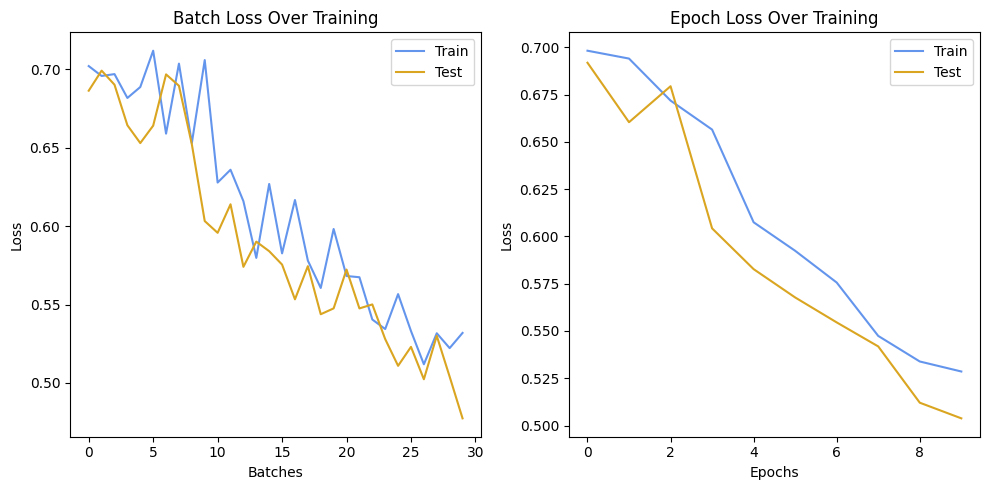

In [29]:
plt.figure(figsize=(10, 5))

# Plot batch loss
plt.subplot(1, 2, 1)
plt.plot(batch_train_losses, label='Train', color='cornflowerblue')
plt.plot(batch_test_losses, label='Test', color='goldenrod')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Batch Loss Over Training')
plt.legend()

# Plot epoch loss
plt.subplot(1, 2, 2)
plt.plot(epoch_train_losses, label='Train', color='cornflowerblue')
plt.plot(epoch_test_losses, label='Test', color='goldenrod')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch Loss Over Training')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

## 2. Predictions

In [30]:
# Read predictions from the best model and merge them with the original dataset
results = pd.read_csv("output/preds/epoch_10.csv")
results = pd.merge(test, results, on = 'review_id')

In [31]:
# Check for consistency
print("Do the true labels returned by the model match the original sentiments?")
print("Yes!" if (results['sentiment'] == results['true_label']).all() else "No :'(")

Do the true labels returned by the model match the original sentiments?
Yes!


### Assess certainty

In [32]:
print(f"Number of ties: {(results['prob_class_0'] == results['prob_class_1']).sum()}")

Number of ties: 0


In [33]:
E = (1 - np.maximum(results['prob_class_0'], results['prob_class_1'])).mean()
print(f"Classification error {E:.3f}")

Classification error 0.338


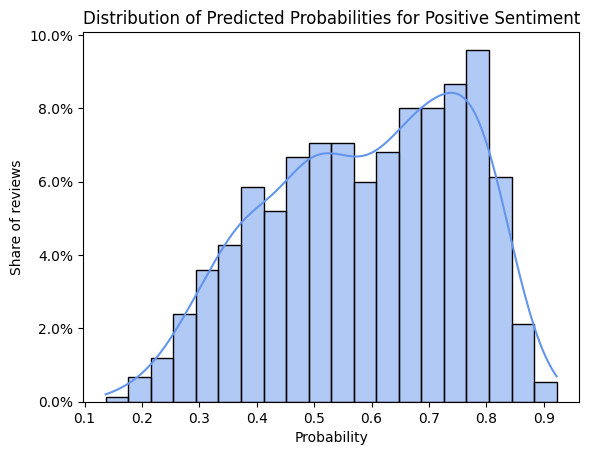

In [51]:
sns.histplot(results['prob_class_1'], bins=20, color="cornflowerblue", kde=True, stat="probability")
plt.xlabel("Probability")
plt.ylabel("Share of reviews")
plt.title("Distribution of Predicted Probabilities for Positive Sentiment")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.1f}%'))
plt.show()

### Get predicted sentiments and save

In [ ]:
results['RoBERTa_ft'] = np.where(results['prob_class_1'] >= 0.5, 'positive', 'negative')

In [ ]:
results[['review_id', 'ft_RoBERTa']].to_csv("output/ft_RoBERTa.csv")

### Assess performance

In [ ]:
accuracy = accuracy_score(results['sentiment'], results['RoBERTa_ft'])
print(f"Accuracy: {accuracy:.4f}")

In [ ]:
cm = confusion_matrix(results['sentiment'], results['RoBERTa_ft'], labels=['negative', 'positive'])

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()